In [0]:
# ============================================================
# 🚄 USE CASE 2: Service Aspect Analysis (IRCTC)
# ============================================================
# Goal:
# Identify which service aspects (Food, Cleanliness, Booking, App issues)
# passengers talk about the most — and analyze sentiment for each.
#
# Reusing the SAME NLP + ML pipeline from Use Case 1:
# Tokenization → Stopword Removal → TF-IDF → Classification
# ============================================================

# ------------------------------------------------------------
# 🧩 Step 1: Import Libraries & Initialize Spark
# ------------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, udf
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("IRCTC_Service_Aspect_Analysis").getOrCreate()
print("✅ Spark session started successfully!")

✅ Spark session started successfully!


In [0]:
# ------------------------------------------------------------
# 📂 Step 2: Load Dataset
# ------------------------------------------------------------
file_path = "/Volumes/workspace/default/dataset2/irctc_reviews.csv"
df = spark.read.option("header", "true").csv(file_path)
print(f"✅ Dataset Loaded Successfully | Total Rows: {df.count()}")
df.show(5, truncate=False)

✅ Dataset Loaded Successfully | Total Rows: 1000
+------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|reviewId                            |userName     |content                                                                                                                                                                                                                                                                                                                                                                |score|
+------------------------------------+-------------+-------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧼 Step 3: Data Cleaning & Label Creation
# ------------------------------------------------------------
# Safe score conversion
def safe_to_int(x):
    try:
        return int(x)
    except:
        return None

safe_to_int_udf = udf(safe_to_int, IntegerType())
df = df.withColumn("score_int", safe_to_int_udf(trim(col("score"))))
df = df.filter(col("score_int").isNotNull() & col("content").isNotNull())

# Clean text
df = df.withColumn("review", lower(regexp_replace(trim(col("content")), "[^a-zA-Z\\s]", "")))

# Label encoding: 0=Negative, 1=Neutral, 2=Positive
df = df.withColumn(
    "label",
    when(col("score_int") >= 4, 2)
    .when(col("score_int") == 3, 1)
    .otherwise(0)
)
print("✅ Data cleaned and labeled successfully!")
df.select("review", "score_int", "label").show(5, truncate=False)

✅ Data cleaned and labeled successfully!
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+
|review                                                                                                                                                                                                                                                                                                                                                              |score_int|label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧠 Step 4: Reusable NLP Pipeline (Same as Use Case 1)
# ------------------------------------------------------------
tokenizer = Tokenizer(inputCol="review", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Using Logistic Regression (best from UC1)
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

# Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
print("✅ Reusable NLP + ML Pipeline ready!")

✅ Reusable NLP + ML Pipeline ready!


In [0]:
# ------------------------------------------------------------
# 🎯 Step 5: Train-Test Split & Model Training
# ------------------------------------------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
lr_model = pipeline.fit(train_df)
predictions = lr_model.transform(test_df)
print("✅ Model trained successfully on cleaned IRCTC reviews!")

✅ Model trained successfully on cleaned IRCTC reviews!


In [0]:
# ------------------------------------------------------------
# 🧩 Step 6: Define Service Aspects
# ------------------------------------------------------------
aspects = {
    "food": ["food", "meal", "taste", "catering", "snack"],
    "cleanliness": ["clean", "dirty", "toilet", "washroom", "hygiene"],
    "booking": ["book", "ticket", "refund", "cancel", "payment", "pnr"],
    "app": ["app", "login", "crash", "update", "slow", "interface"]
}

# Detect aspects using a UDF
def detect_aspects(text):
    if not text:
        return "others"
    text_words = text.split()
    detected = []
    for aspect, keywords in aspects.items():
        for word in keywords:
            if word in text_words:
                detected.append(aspect)
                break
    return ",".join(detected) if detected else "others"

detect_aspect_udf = udf(detect_aspects, StringType())
predictions = predictions.withColumn("aspect", detect_aspect_udf(col("review")))
print("✅ Detected key service aspects in each review!")

✅ Detected key service aspects in each review!


✅ Aspect-wise sentiment counts:
+-----------+-----+-----+
|aspect     |label|count|
+-----------+-----+-----+
|app        |0    |66   |
|app        |1    |5    |
|app        |2    |6    |
|booking    |0    |4    |
|booking,app|0    |21   |
|food       |2    |2    |
|food,app   |0    |1    |
|others     |0    |30   |
|others     |1    |2    |
|others     |2    |24   |
+-----------+-----+-----+



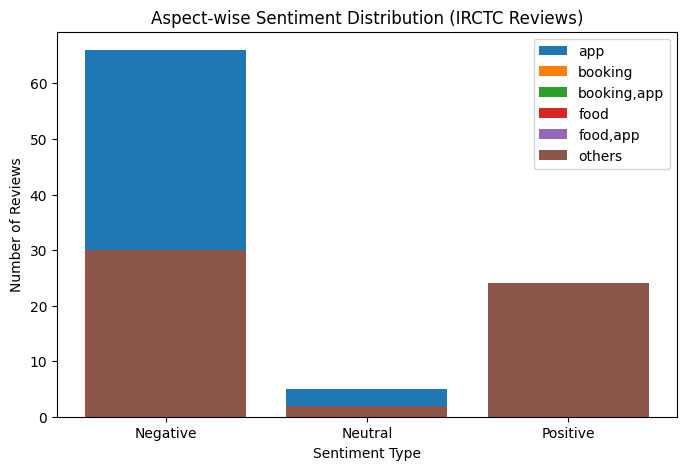

In [0]:
# ------------------------------------------------------------
# 📊 Step 7: Aspect-Wise Sentiment Distribution
# ------------------------------------------------------------
from pyspark.sql.functions import count

aspect_sentiment = (
    predictions.groupBy("aspect", "label")
    .agg(count("*").alias("count"))
    .orderBy("aspect", "label")
)

print("✅ Aspect-wise sentiment counts:")
aspect_sentiment.show(truncate=False)

# Convert to Pandas for chart
aspect_pd = aspect_sentiment.toPandas()

# Label names for visualization
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
aspect_pd["Sentiment"] = aspect_pd["label"].map(label_map)

plt.figure(figsize=(8,5))
for aspect in aspect_pd["aspect"].unique():
    subset = aspect_pd[aspect_pd["aspect"] == aspect]
    plt.bar(subset["Sentiment"], subset["count"], label=aspect)

plt.title("Aspect-wise Sentiment Distribution (IRCTC Reviews)")
plt.xlabel("Sentiment Type")
plt.ylabel("Number of Reviews")
plt.legend()
plt.show()

In [0]:
# ------------------------------------------------------------
# 💬 Step 8: Generate Insights
# ------------------------------------------------------------
print("\n🔍 Insights Summary:")
for asp in aspect_pd["aspect"].unique():
    subset = aspect_pd[aspect_pd["aspect"] == asp]
    pos = int(subset[subset["Sentiment"] == "Positive"]["count"].sum())
    neg = int(subset[subset["Sentiment"] == "Negative"]["count"].sum())
    print(f"➡️ {asp.capitalize()} → Positive: {pos} | Negative: {neg}")

print("\n✅ Use Case 2 executed successfully — Aspect Sentiment Analysis completed!")



🔍 Insights Summary:
➡️ App → Positive: 6 | Negative: 66
➡️ Booking → Positive: 0 | Negative: 4
➡️ Booking,app → Positive: 0 | Negative: 21
➡️ Food → Positive: 2 | Negative: 0
➡️ Food,app → Positive: 0 | Negative: 1
➡️ Others → Positive: 24 | Negative: 30

✅ Use Case 2 executed successfully — Aspect Sentiment Analysis completed!


In [0]:
# ------------------------------------------------------------
# 💾 Step 9: Save Aspect-Wise Results for Reporting
# ------------------------------------------------------------
output_df = predictions.select("review", "aspect", "label")
output_path = "/Workspace/exports/IRCTC_Service_Aspect_Analysis_Results.csv"
output_df.toPandas().to_csv(output_path, index=False)
print(f"📁 Aspect analysis results saved at: {output_path}")

📁 Aspect analysis results saved at: /Workspace/exports/IRCTC_Service_Aspect_Analysis_Results.csv
